# Building Clusters with Weekend Movie Data

For this project, we will be examining Weekend Movie data. I chose to use the smaller data set by convenience because the larger dataset is not capable of being added to the repo

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from numpy import unique 
from numpy import where
from os import path 

Generating the dataframes from each of our different csv input files.

In [2]:
classes = ['links', 'movies', 'ratings', 'tags', 'genome-scores', 'genome-tags']
for i in classes: 
    file = 'ml-latest/'
    file += i
    file  += '.csv'
    i = i.replace("-", "_")
    globals()[i]= pd.read_csv(file)

## Big Data 
These datasets are rather large. Let's get an idea of the scale of it all. 

### Ratings
Ratings are created by users for a specific film with a decimal value rating between 0-5

In [3]:
print("Number of ratings: %d" % ratings.shape[0])
ratings.head()

Number of ratings: 27753444


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


### Movies 
Movies are pretty straight forward and will be referenced in other data sets

In [4]:
print("Number of movies: %d" % movies.shape[0])
movies.head()

Number of movies: 58098


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Genome tags and scores 
Genome scores and tags are great for the clustering analysis. The `genome-scores` dataset tells us the relevancy of a certain tag to a certain movie. `genome-tags` gives us a translation from a tagId to it's actual tag value. 

In [5]:
print("Genome Tags: %d" % genome_tags.shape[0])
genome_tags.head()

Genome Tags: 1128


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [6]:
print("Genome Scores: %d" % genome_scores.shape[0])
genome_scores.head()

Genome Scores: 14862528


,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


# Feature Engineering

We will need to define our way of clustering films into different.. well.. clusters. We'll define similarities among films based on rating and tags.

From our Averages of Ratings and Number of Ratings per film datasets, we can form a larger set which will then be merged into our larger movies dataset. 

Because of how much we've already modified our data, let's save it as a processed file. Just to be fancy, let's name it `films.csv` because _Film_ sounds more thought out and "processed" than _Movie_.

In [7]:
if path.exists("data/processed/films.csv"):
    movies = pd.read_csv("data/processed/films.csv")
    movies.drop(movies.columns[0], inplace=True, axis=1)
else:
    avg_ratings = pd.DataFrame(ratings.groupby("movieId").apply(lambda row: np.average(row["rating"])), columns=["avgRating"])
    num_ratings = pd.DataFrame(ratings[["movieId", "userId"]].groupby("movieId").agg("count")).rename({"userId": "numOfRatings"}, axis=1)
    merged_ratings = avg_ratings.merge(num_ratings, left_index=True, right_index=True)
    movies = movies.merge(merged_ratings, left_on="movieId", right_index=True)
    movies.to_csv("data/processed/films.csv")

In [8]:
movies.head()

,movieId,title,genres,avgRating,numOfRatings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649,68469
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.246583,27143
2,3,Grumpier Old Men (1995),Comedy|Romance,3.173981,15585
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.874540,2989
4,5,Father of the Bride Part II (1995),Comedy,3.077291,15474


In [9]:
movie_ids = np.intersect1d(movies["movieId"].unique(), genome_scores["movieId"].unique())

In [10]:
movies = movies[np.isin(movies["movieId"], movie_ids)]

In [11]:
genome_scores = genome_scores[np.isin(genome_scores["movieId"], movie_ids)]

# Cluster Analysis
Let's break our analysis into two parts. For the first, we'll isolate a single film (The Truman Show), and find films similar using clustering through ratings and tags. Secondly, we'll use a similar approach with the popular KMeans clustering algorithm.

In [12]:
truman_show = movies.loc[movies["title"].str.contains("Truman Show")]

In [13]:
ts_id, ts_title, ts_rating = truman_show["movieId"].values[0], truman_show["title"].values[0], truman_show["avgRating"].values[0]
print("ID: %s" % ts_id)
print("TITLE: %s" % ts_title)
print("RATING: %s" % ts_rating)

ID: 1682
TITLE: Truman Show, The (1998)
RATING: 3.8455269880053313


For clustering based on tagging, we should grab the relevant tags from "The Truman Show" as a centerpoint for our clustering process. 

In [14]:
truman_show_tags = genome_scores[genome_scores["movieId"] == ts_id].sort_values(by=["relevance"], ascending=False).take([0,1,2])
tag_ids = truman_show_tags["tagId"].values
for i in [0,1,2]:
    print("%s" % genome_tags["tag"][genome_tags["tagId"] == tag_ids[i]].values[0])

reality tv
original
modern fantasy


In [15]:
test_data = pd.DataFrame(movies)

if path.exists("data/processed/test_data.csv"):
    test_data = pd.read_csv("data/processed/test_data.csv")
    test_data.drop(test_data.columns[0], inplace=True, axis=1)
else:
    def relativity(row):
        mid = row["movieId"]
        g_tags = genome_scores.loc[genome_scores["movieId"] == mid]
        return sum(g_tags.loc[g_tags["tagId"].isin(tag_ids), "relevance"])

    test_data["relativityFactor"] = test_data.apply(relativity, axis=1)
    test_data.to_csv("data/processed/test_data.csv")


In [16]:
test_data.head()

,movieId,title,genres,avgRating,numOfRatings,relativityFactor
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649,68469,1.13550
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.246583,27143,0.93400
2,3,Grumpier Old Men (1995),Comedy|Romance,3.173981,15585,0.88500
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.874540,2989,0.79200
4,5,Father of the Bride Part II (1995),Comedy,3.077291,15474,0.86375


In [17]:
movie_relativity = pd.Series(test_data["relativityFactor"].values, index=test_data["movieId"])
movie_ratings = pd.Series(test_data["avgRating"].values, index=test_data["movieId"])

data = np.array(list(zip(movie_ratings.values, movie_relativity.values, movie_ratings.index)))
data = np.array(list(filter(lambda d: d[1] > 1, data)))

# Passing the Truman Show ID
test_data_idx = np.where(data[:, 2] == ts_id)[0][0]
truman_show_relativity_factor = data[test_data_idx, 1]

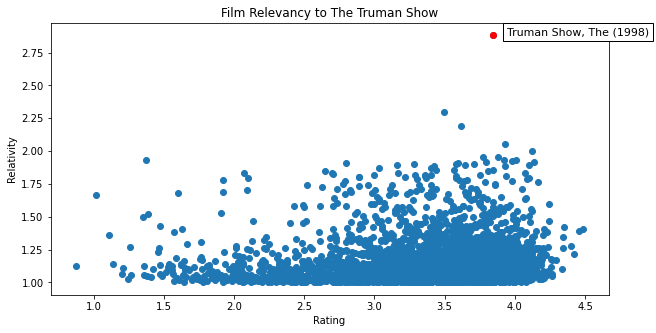

In [18]:
plt.figure(figsize=(10, 5))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Film Relevancy to The Truman Show")
plt.ylabel("Relativity")
plt.xlabel("Rating")

# Special label for our film of focus "The Truman Show"
plt.scatter(ts_rating, truman_show_relativity_factor, c='r')
plt.text(ts_rating + 0.1, truman_show_relativity_factor, ts_title, fontsize= 11, bbox=dict(facecolor='white'))

plt.show()

Interesting. We have here Truman Show sitting in the middle of the pack. Let's jump to using this data in K-Means to provide more suggestions for future movie nights! 

# Building Clusters - K-Means

In [19]:
kmeans = KMeans(n_clusters=10).fit(data[:, :2])
labels = kmeans.labels_

movie_cluster = labels[test_data_idx]
related_movie_idxs = np.where(labels == movie_cluster)
related_movie_ids = data[related_movie_idxs][:, 2]
kmeans_related_movies = test_data[test_data["movieId"].isin(related_movie_ids)].sort_values(by=["relativityFactor"], ascending=False)

In [20]:
# Getting rid of our film of focus
kmeans_related_movies = kmeans_related_movies.drop(kmeans_related_movies.index[0])

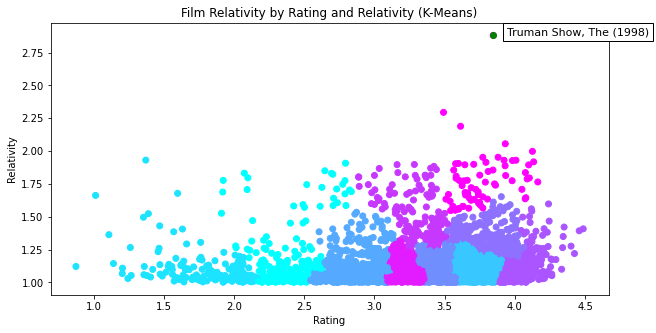

In [27]:
plt.figure(figsize=(10, 5))
plt.cool()

plt.scatter(data[:, 0], data[:, 1], c=labels)

plt.title("Film Relativity by Rating and Relativity (K-Means)")
plt.xlabel("Rating")
plt.ylabel("Relativity")

plt.scatter(ts_rating, truman_show_relativity_factor, c='g')
plt.text(ts_rating + 0.1, truman_show_relativity_factor, ts_title, fontsize=11, bbox=dict(facecolor='white'))

plt.show()

# Building Clusters - Hierarchical Agglomerative 

In [22]:
agg = AgglomerativeClustering(n_clusters=10).fit(data[:, :2])
labels = agg.labels_

movie_cluster = labels[test_data_idx]
related_movie_idxs = np.where(labels == movie_cluster)
related_movie_ids = data[related_movie_idxs][:, 2]
agg_related_movies = test_data[test_data["movieId"].isin(related_movie_ids)].sort_values(by=["relativityFactor"], ascending=False)

In [23]:
# Getting rid of our film of focus
agg_related_movies = agg_related_movies.drop(agg_related_movies.index[0])

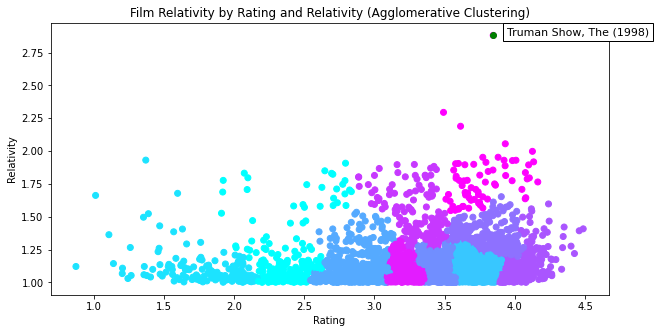

In [28]:
plt.figure(figsize=(10, 5))
plt.cool()

plt.scatter(data[:, 0], data[:, 1], c=labels)

plt.title("Film Relativity by Rating and Relativity (Agglomerative Clustering)")
plt.xlabel("Rating")
plt.ylabel("Relativity")

plt.scatter(ts_rating, truman_show_relativity_factor, c='g')
plt.text(ts_rating + 0.1, truman_show_relativity_factor, ts_title, fontsize=11, bbox=dict(facecolor='white'))

plt.show()

# Conclusion 

In [31]:
truman_show.head()

,movieId,title,genres,avgRating,numOfRatings
1625,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,3.845527,36016


In [29]:
kmeans_related_movies.head()

,movieId,title,genres,avgRating,numOfRatings,relativityFactor
22209,106236,Somm (2012),Documentary,3.491667,60,2.29450
18948,93840,"Cabin in the Woods, The (2012)",Comedy|Horror|Sci-Fi|Thriller,3.613047,6055,2.18875
2912,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy,3.931551,33390,2.05525
1172,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.124808,42878,1.99775
9256,27251,"10th Kingdom, The (2000)",Adventure|Comedy|Fantasy,3.880522,498,1.95275


In [30]:
agg_related_movies.head()

,movieId,title,genres,avgRating,numOfRatings,relativityFactor
22209,106236,Somm (2012),Documentary,3.491667,60,2.29450
18948,93840,"Cabin in the Woods, The (2012)",Comedy|Horror|Sci-Fi|Thriller,3.613047,6055,2.18875
2912,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy,3.931551,33390,2.05525
1172,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.124808,42878,1.99775
9256,27251,"10th Kingdom, The (2000)",Adventure|Comedy|Fantasy,3.880522,498,1.95275


Wow. The Truman Show stands far above on it's own among the dataset. This tells us that The Truman Show does not have many common films like it. Both the KMeans and Agglomerative Clustering yielded similar results. 

The suggested films include Comedic, Drama and Sci-Fi/Fantasy films. All of which are genres of our central film The Truman Show. Both the K-Means and Hierarchcial Agglomeritive Clustering methods seem to be very similar to one another. K-Means was an easy choice to use as it has proven to be direct and fast with a large popularity in the Data Science field. The HAC method builds clusters in a tree-like "hierarchical" structure which was convenient in our visualizing of t 